# An objective function with an equality constraint. 
## pySOT only supports inequality constraints through projections, so this examples considers an equality constraint that is easy to project onto


In [1]:
class AckleyUnit:
    def __init__(self, dim=10):
        self.xlow = -1 * np.ones(dim)
        self.xup = 1 * np.ones(dim)
        self.dim = dim
        self.info = str(dim)+"-dimensional Ackley function on the unit sphere \n" +\
                             "Global optimum: f(1,0,...,0) = ... = f(0,0,...,1) = " +\
                             str(np.round(20*(1-np.exp(-0.2/np.sqrt(dim))), 3))
        self.min = 20*(1 - np.exp(-0.2/np.sqrt(dim)))
        self.integer = []
        self.continuous = np.arange(0, dim)
        check_opt_prob(self)

    def objfunction(self, x):
        n = float(len(x))
        return -20.0 * np.exp(-0.2*np.sqrt(np.sum(x**2)/n)) - \
            np.exp(np.sum(np.cos(2.0*np.pi*x))/n) + 20 + np.exp(1)

    def eval_eq_constraints(self, x):
        return np.linalg.norm(x) - 1

## Pick your options

In [3]:
# Import the necessary modules
from pySOT import *
from poap.controller import ThreadController, BasicWorkerThread
import numpy as np

# Decide how many evaluations we are allowed to use
maxeval = 500

# (1) Optimization problem
# Use the 10-dimensional Ackley function
data = AckleyUnit(dim=10)
print(data.info)

# (2) Experimental design
# Use a symmetric Latin hypercube with 2d + 1 samples
exp_des = SymmetricLatinHypercube(dim=data.dim, npts=2*data.dim + 1)

# (3) Surrogate model
# Use a cubic RBF interpolant with a linear tail
surrogate = RBFInterpolant(kernel=CubicKernel, tail=LinearTail, maxp=maxeval)

# (4) Adaptive sampling
# Use DYCORS with 100d candidate points
adapt_samp = CandidateDYCORS(data=data, numcand=100*data.dim)

# (NEW) Projection
# Specify how to project onto the equality constraint
# This is used for the candidate points
def projection(x):
    return x / np.linalg.norm(x)

10-dimensional Ackley function on the unit sphere 
Global optimum: f(1,0,...,0) = ... = f(0,0,...,1) = 1.226


## Use the projection strategy

In [4]:
# Use the threaded controller
controller = ThreadController()

# (5) Use the sychronous strategy without non-bound constraints
# Use 4 threads and allow for 4 simultaneous evaluations
nthreads = 4
strategy = SyncStrategyProjection(
        worker_id=0, data=data, maxeval=maxeval, nsamples=nthreads,
        exp_design=exp_des, response_surface=surrogate, 
        sampling_method=adapt_samp, proj_fun=projection)
controller.strategy = strategy

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

Best value found: 1.22580270019
Best solution found: [-0.00025 -0.00187 -0.99999 -0.00155  0.00073  0.00032 -0.00142 -0.00112 -0.00021  0.00124]


## Make a progress plot

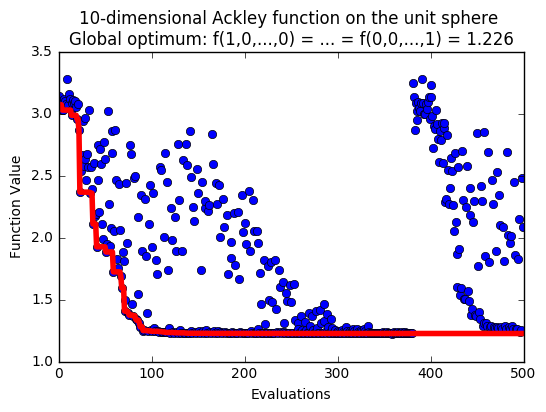

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract function values from the controller
fvals = np.array([o.value for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

## Written by, David Eriksson, dme65@cornell.edu
